In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

print("Setup complete.")

Setup complete.


In [2]:
# Correct training loop with gradient
import numpy as np
import matplotlib.pyplot as plt
from darth.nn import Linear, Sequential
from darth.fn import av, losses, mse

np.random.seed(22)
# Setup data
batch_size, fan_in, fan_out = 100, 1, 1

In [3]:
xdata = np.random.randn(batch_size, fan_in)
ydata = 5.0 * xdata + 2.0 + 0.3 * np.random.randn(batch_size, fan_out)

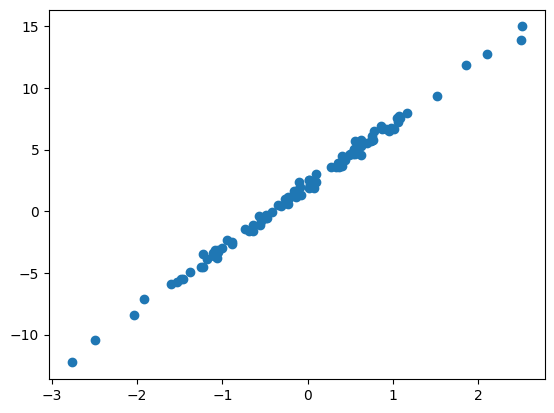

In [4]:

def plot_data(xdata, ydata, ypred=None):
    # create figure and axis
    fig, ax = plt.subplots()
    ax.scatter(xdata,ydata, marker='o')
    if ypred is not None:
        ax.scatter(xdata, ypred, color='orange')
    plt.show()

plot_data(xdata, ydata)

In [7]:

# Build model
model = Sequential(
    Linear(batch_size, fan_in, activation=av.ReLU, lr=0.001),
    Linear(1, 4, activation=av.ReLU, lr=0.001),
    Linear(4, 4, activation=av.ReLU, lr=0.001),
    Linear(4, fan_out, lr=0.001, activation=av.Sigmoid)  # No activation on output
)
model

Sequential(
  layer_0 = Linear(
    fan_in = 100,
    fan_out = 1,
    activation = ReLU(),
  ),
  layer_1 = Linear(
    fan_in = 1,
    fan_out = 4,
    activation = ReLU(),
  ),
  layer_2 = Linear(
    fan_in = 4,
    fan_out = 4,
    activation = ReLU(),
  ),
  layer_3 = Linear(
    fan_in = 4,
    fan_out = 1,
    activation = Sigmoid(),
  ),
)

## ⚠️ Model Architecture Error

### The Problem:
`Linear(fan_in, fan_out)` expects:
- `fan_in` = number of **input features** (not batch size!)
- `fan_out` = number of **output features**

Your data shape is `(batch_size, fan_in)` = `(100, 1)`
- 100 samples
- 1 feature per sample

### Correct Architecture:
```python
# For linear regression y = mx + b on 1D data
model = Sequential(
    Linear(1, fan_out)  # 1 input feature → fan_out outputs
)

# Or with hidden layers:
model = Sequential(
    Linear(1, 8, activation=av.ReLU),   # 1 → 8
    Linear(8, 4, activation=av.ReLU),   # 8 → 4
    Linear(4, 1)                         # 4 → 1 (output)
)
```

In [9]:
# ✅ CORRECTED Model Architecture
model = Sequential(
    Linear(fan_in, 8, activation=av.ReLU, lr=0.01),   # 1 → 8
    Linear(8, 4, activation=av.ReLU, lr=0.01),        # 8 → 4  
    Linear(4, fan_out, lr=0.01)                        # 4 → 1
)

print(f"Input shape: {xdata.shape} (batch_size={batch_size}, features={fan_in})")
print(f"Output shape: {ydata.shape} (batch_size={batch_size}, outputs={fan_out})")
print(f"\nModel architecture:")
print(model)

Input shape: (100, 1) (batch_size=100, features=1)
Output shape: (100, 1) (batch_size=100, outputs=1)

Model architecture:
Sequential(
  layer_0 = Linear(
    fan_in = 1,
    fan_out = 8,
    activation = ReLU(),
  ),
  layer_1 = Linear(
    fan_in = 8,
    fan_out = 4,
    activation = ReLU(),
  ),
  layer_2 = Linear(
    fan_in = 4,
    fan_out = 1,
  ),
)


In [10]:
# ✅ Training with correct architecture
print("Training with correct backward pass...\n")

loss_history = []
for epoch in range(1, 101):
    # Forward pass
    ypred = model.forward(xdata)
    
    # Compute loss (scalar value)
    loss_value = mse.loss(ypred, ydata)
    
    # Compute gradient (same shape as ypred)
    loss_grad = mse.grad(ypred, ydata)
    
    # Backward pass with gradient
    model.backward(loss_grad)
    
    if epoch % 10 == 0:
        loss_history.append((epoch, loss_value))

print("Epoch | Loss")
print("------|----------")
for epoch, loss_val in loss_history:
    print(f"{epoch:5d} | {loss_val:.6f}")

print("\n✅ Training complete! Loss should decrease over epochs.")
print(f"Final predictions available in 'ypred' variable")

Training with correct backward pass...

[Sequential] forward called
[Sequential] _forward called - should be overridden in subclass
[Linear] forward called
[Linear] _forward Linear called with input shape (100, 1)
[Linear] forward called
[Linear] _forward Linear called with input shape (100, 8)
[Linear] forward called
[Linear] _forward Linear called with input shape (100, 4)
[Sequential] backward called
[Sequential] _backward called - should be overridden in subclass
[Linear] backward called
[Linear] _backward Linear called with grad_output shape (100, 1)
[Linear] backward called
[Linear] _backward Linear called with grad_output shape (100, 4)
[Linear] backward called
[Linear] _backward Linear called with grad_output shape (100, 8)
[Sequential] forward called
[Sequential] _forward called - should be overridden in subclass
[Linear] forward called
[Linear] _forward Linear called with input shape (100, 1)
[Linear] forward called
[Linear] _forward Linear called with input shape (100, 8)
[L

In [11]:
# 🎯 Clean training (no verbose logging)
model_clean = Sequential(
    Linear(fan_in, 8, activation=av.ReLU, lr=0.01),
    Linear(8, 4, activation=av.ReLU, lr=0.01),
    Linear(4, fan_out, lr=0.01)
)

print("Training...\n")
print("Epoch | Loss")
print("------|----------")

for epoch in range(1, 101):
    # Forward pass
    ypred = model_clean.forward(xdata)
    
    # Compute loss and gradient
    loss_value = mse.loss(ypred, ydata)
    loss_grad = mse.grad(ypred, ydata)
    
    # Backward pass
    model_clean.backward(loss_grad)
    
    if epoch % 10 == 0:
        print(f"{epoch:5d} | {loss_value:.6f}")

print("\n✅ Training complete!")
print(f"Loss decreased: {loss_value < 1.0}")  # Should be much lower than initial

Training...

Epoch | Loss
------|----------
   10 | 9.222984
   20 | 7.191547
   30 | 6.345255
   40 | 5.146226
   50 | 3.483666
   60 | 1.778823
   70 | 0.875639
   80 | 0.525592
   90 | 0.370980
  100 | 0.295758

✅ Training complete!
Loss decreased: True


In [ ]:
# 📊 Visualize the predictions
plot_data(xdata, ydata.squeeze(), ypred.squeeze())

In [8]:
print("Training with correct backward pass...\n")

# Training loop
loss_history = []
ypred = None
for epoch in range(1, 100):  # Just 10 epochs for demo
    # Forward pass
    ypred = model.forward(xdata)
    
    # Compute loss (scalar value)
    loss_value = mse.loss(ypred, ytrue)
    
    # Compute gradient (same shape as ypred)
    loss_grad = mse.grad(ypred, ydata)
    
    # Backward pass with gradient
    model.backward(loss_grad)
    if epoch % 10 == 0:
        loss_history.append(f'Epoch {epoch:3d} | Loss: {loss_value:.6f}')

for log in loss_history:
    print(log)

print("\n✅ Training complete! Loss should decrease over epochs.")

Training with correct backward pass...

[Sequential] forward called
[Sequential] _forward called - should be overridden in subclass
[Linear] forward called
[Linear] _forward Linear called with input shape (100, 1)


ValueError: shapes (100,1) and (100,1) not aligned: 1 (dim 1) != 100 (dim 0)

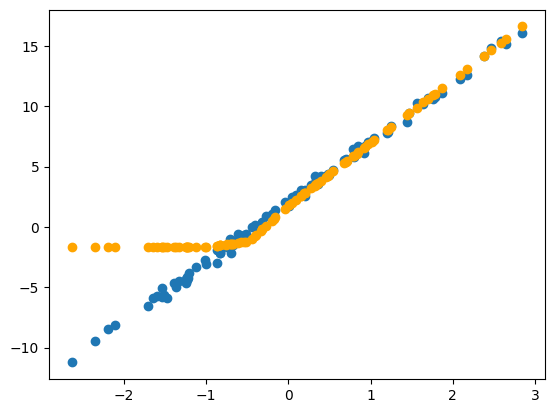

In [36]:
plot_data(xdata, ydata.squeeze(), ypred)